This is the notebook for converting the model file to moog format and other things.

In [1]:
import pymoog
from astropy import constants
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial import Delaunay
import os
import pickle

%matplotlib inline

# MARCS model I/O and convert

In [5]:
marcs_model = pymoog.model.read_marcs_model('marcs_model/st/s/s2500_g+2.0_m1.0_t02_st_z-2.00_a+0.40_c+0.00_n+0.00_o+0.40_r+0.00_s+0.00.mod')
pymoog.model.save_marcs_model(marcs_model, 'temp2.txt')
pymoog.model.marcs2moog(marcs_model, 'temp3.txt', abun_change={3:-0.5, 4:0.5}, molecules=[101, 106, 808])

In [6]:
s = pymoog.synth.synth(2500, 2.0, -2, 4000, 4100, 50000)
s.prepare_file()
s.run_moog(output=True)
s.read_spectra()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER synth  
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
RAW SYNTHESIS OUTPUT; here is the filename: MOOG.out2                           
SMOOTHED SYNTHESES OUTPUT; here is the filename: MOOG.out3                      
THE MODEL ATMOSPHERE; here is the filename: temp3.txt                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


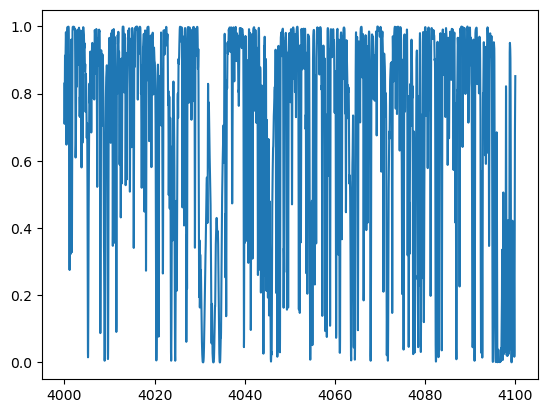

In [7]:
plt.plot(s.wav, s.flux)

# MARCS grid 

In [661]:
# Here we calculate the Delaunay triangulation for MRACS models, and sotre them into corredponding folders.
def save_marcs_delaunay(folder_path, tri_columns=['teff', 'g', '[M/H]', 'vmicro', 'mass']):
    '''
    Generate the DataFrame of grid points and Delaunay triangulation for MARCS models, and save it to the same folder. For internal use.
    
    Parameters
    ----------
    folder_path : str
        The folder path for generating the grid points DataFrame and Delaunay triangulation.
    tri_columns : list
        List of columns to be used for Delaunay triangulation.
    '''
    marcs_name_list = os.listdir(folder_path)
    marcs_name_list = [i for i in marcs_name_list if 'mod' in i]
    marcs_grid = []

    for model in marcs_name_list:
        marcs_grid.append(list(marcs_filename2gridpoint(model).values()))

    marcs_grid = pd.DataFrame(marcs_grid, columns=['chem', 'geo', 'teff', 'logg', 'mass', 'vmicro', '[M/H]', '[alpha/Fe]', 
                                                           '[C/Fe]', '[N/Fe]', '[O/Fe]', 'r', 's'])    
    marcs_grid['g'] = 10**marcs_grid['logg']
    
    # Sanity check: chem and geo have to be the same in the dataframe.
    if len(marcs_st_p_grid.groupby(['chem', 'geo']).size()) > 1:
        raise ValueError('Chemical composition or model geometry is not unique in the folder. Please limit them to only one.')
        
    grid_matrix = np.array(marcs_grid[tri_columns])
    tri = Delaunay(grid_matrix)
    
    marcs_grid.to_csv(folder_path + '/grid_points.csv', index=False)
    pickle.dump(tri, open(folder_path + '/tri.pkl', 'wb'))
    
    pass

In [662]:
save_marcs_delaunay('marcs_model/st/s/')

In [663]:
save_marcs_delaunay('marcs_model/st/p/', tri_columns=['teff', 'g', '[M/H]', 'vmicro'])

In [697]:
save_marcs_delaunay('marcs_model/hc/s/')

In [698]:
save_marcs_delaunay('marcs_model/mc/s/')

In [664]:
marcs_grid = {'st':{}, 'mc':{}}
marcs_tri = {'st':{}, 'mc':{}}

marcs_grid['st']['s'] = pd.read_csv('marcs_model/st/s/grid_points.csv')
marcs_tri['st']['s'] = pickle.load(open('marcs_model/st/s/tri.pkl', 'rb'))

marcs_grid['st']['p'] = pd.read_csv('marcs_model/st/p/grid_points.csv')
marcs_tri['st']['p'] = pickle.load(open('marcs_model/st/p/tri.pkl', 'rb'))

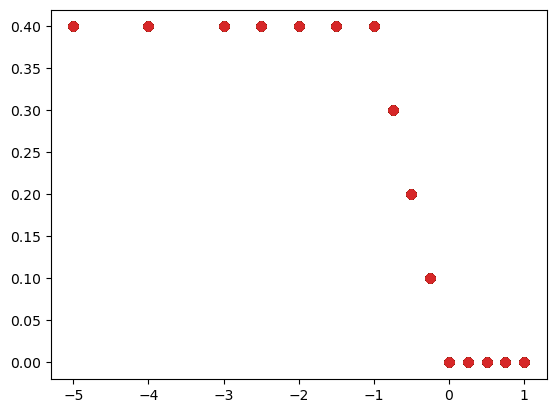

In [547]:
plt.scatter(marcs_st_s_grid['[M/H]'], marcs_st_s_grid['[alpha/Fe]'])
plt.scatter(marcs_st_s_grid['[M/H]'], marcs_st_s_grid['[O/Fe]'])

plt.scatter(marcs_st_p_grid['[M/H]'], marcs_st_p_grid['[alpha/Fe]'])
plt.scatter(marcs_st_p_grid['[M/H]'], marcs_st_p_grid['[O/Fe]'])

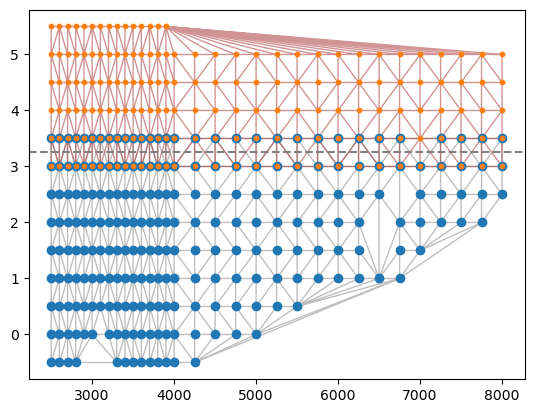

In [557]:
# Plot the Delaunay lines
indices = (marcs_st_s_grid['vmicro'] == 2) & (marcs_st_s_grid['mass'] == 1) & (marcs_st_s_grid['[M/H]'] == 0)
grid_matrix = np.array(marcs_st_s_grid.loc[indices, ['teff', 'logg']])
tri = Delaunay(grid_matrix)
plt.scatter(marcs_st_s_grid.loc[indices, 'teff'], marcs_st_s_grid.loc[indices, 'logg'])
plt.triplot(grid_matrix[:,0], grid_matrix[:,1], tri.simplices, zorder=0, lw=1, color='gray', alpha=0.5)

indices = (marcs_st_p_grid['vmicro'] == 2) & (marcs_st_p_grid['[M/H]'] == 0)
grid_matrix = np.array(marcs_st_p_grid.loc[indices, ['teff', 'logg']])
tri = Delaunay(grid_matrix)
plt.scatter(marcs_st_p_grid.loc[indices, 'teff'], marcs_st_p_grid.loc[indices, 'logg'], s=10)
plt.triplot(grid_matrix[:,0], grid_matrix[:,1], tri.simplices, zorder=0, lw=1, color='brown', alpha=0.5)

plt.axhline(3.25, ls='--', color='gray')

In [4]:
t = interpolate_marcs_model(5060, 4.7, 0)

NameError: name 'z2ao' is not defined

In [694]:
marcs2moog(t, 'temp4.txt')

In [7]:
s = pymoog.synth.synth(5060, 4.7, 0, 4000, 4100, 50000, vmicro=2.5, mass=1.1)
s.prepare_file(model_type='marcs')
s.run_moog(output=True)
s.read_spectra()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER synth  
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
RAW SYNTHESIS OUTPUT; here is the filename: MOOG.out2                           
SMOOTHED SYNTHESES OUTPUT; here is the filename: MOOG.out3                      
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


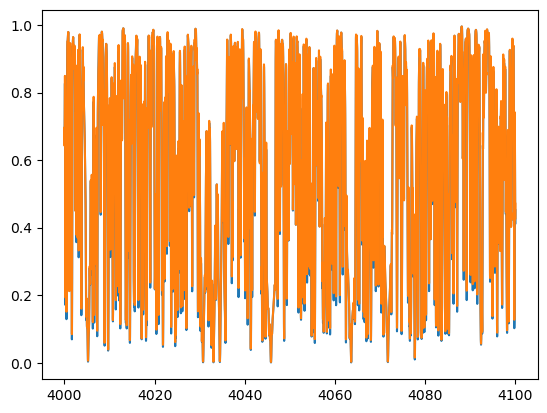

In [8]:
plt.plot(s.wav, s.flux)
plt.plot(s_.wav, s_.flux)

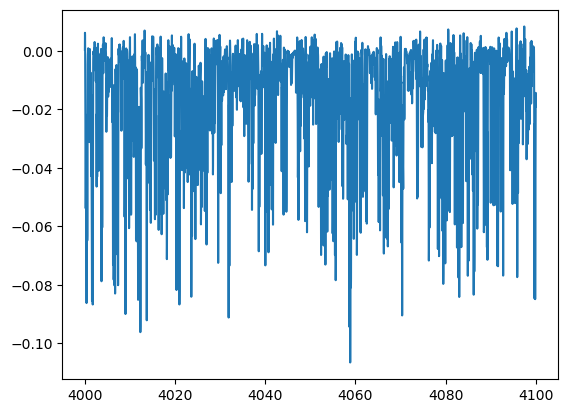

In [9]:
plt.plot(s.wav, s.flux - s_.flux)

In [18]:
pymoog.model.interpolate_marcs_model(5000, 2.2, -0.55)

{'model name': 's5000_g+2.2_m1.0_t02_st_z-0.55_a+0.22_c+0.00_n+0.00_o+0.22_r+0.00_s+0.00.mod',
 'geometry': 'spherical',
 'teff': 5000.0,
 'last iteration': '20080530',
 'flux': 35440000000.0,
 'g': 158.4899235355455,
 'vmicro': 2.0,
 'mass': 1.0,
 '[M/H]': -0.55,
 '[alpha/Fe]': 0.22000000000000003,
 'radius': 1018271046341.802,
 'luminosity': 126.84065763857907,
 'conv:alpha': 1.5,
 'conv:nu': 8.0,
 'conv:y': 0.076,
 'conv:beta': 0.0,
 'X': 0.743614,
 'Y': 0.251348,
 'Z': 0.005037999999999999,
 '12C/13C': 89.0,
 'log abundance': array([ 1.200e+01,  1.093e+01,  5.000e-01,  8.300e-01,  2.150e+00,
         7.840e+00,  7.230e+00,  8.330e+00,  4.010e+00,  7.510e+00,
         5.620e+00,  7.200e+00,  5.820e+00,  7.180e+00,  4.810e+00,
         6.810e+00,  4.950e+00,  5.850e+00,  4.530e+00,  5.980e+00,
         2.620e+00,  4.570e+00,  3.450e+00,  5.090e+00,  4.840e+00,
         6.900e+00,  4.370e+00,  5.680e+00,  3.660e+00,  4.050e+00,
         2.330e+00,  3.030e+00,  1.740e+00,  2.780e+00,  

# Tutorial

## Quick start

Let's create a synthetic spectra without caring about all the details:

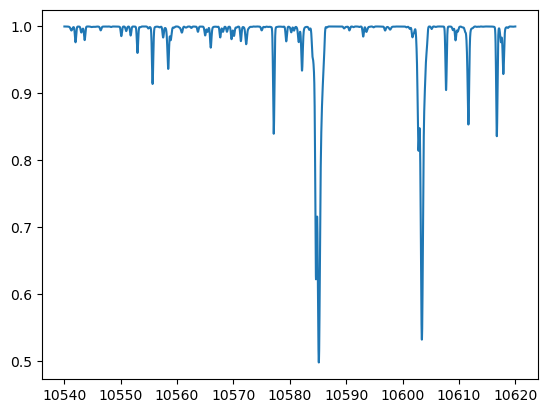

In [13]:
# Basic usage of synth.

#                      Teff, logg, [M/H], start_wavelength, end_wavelength, resolution
s = pymoog.synth.synth(5060,  4.7,     0,            10540,          10620,      50000)
s.prepare_file()
s.run_moog()
s.read_spectra()

# Plot the synthetic spectra
plt.plot(s.wav, s.flux)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 4.77 µs


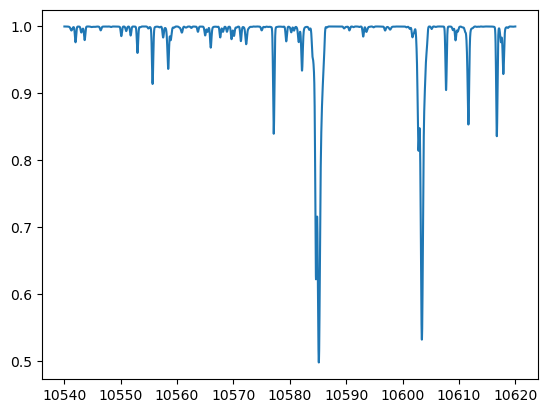

In [8]:
%time
# Basic usage of synth.

#                      Teff, logg, [M/H], start_wavelength, end_wavelength, resolution
s = pymoog.synth.synth(5060,  4.7,     0,            10540,          10620,      50000)
s.prepare_file()
s.run_moog()
s.read_spectra()

# Plot the synthetic spectra
plt.plot(s.wav, s.flux)

The parameters specified here are:
- Teff:
- logg:


## `synth`: creating synthetic spectra

Now let's see what we can control in `synth`, the core part of `pymoog`.

In [16]:
s = pymoog.synth.synth(5060, 4.7, 0, 10540, 10620, 50000, vmicro=2, mass=1, del_wav=0.02, 
                       line_list='vald_3000_24000', weedout=False, prefix='')
s.prepare_file(model_file=None, model_format='moog', loggf_cut=None, abun_change=None, molecules=None, 
               atmosphere=1, lines=1, smooth_para=None, model_type='marcs', model_chem='st', model_geo='auto')
s.run_moog(output=False)
s.read_spectra()

In [13]:
s.run_moog(output=True)

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER binary 
 *******************************************************************************
                                                                                
STANDARD OUTPUT; here is the filename: MOOG.out1                                
RAW SYNTHESIS OUTPUT; here is the filename: MOOG.out2                           
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                


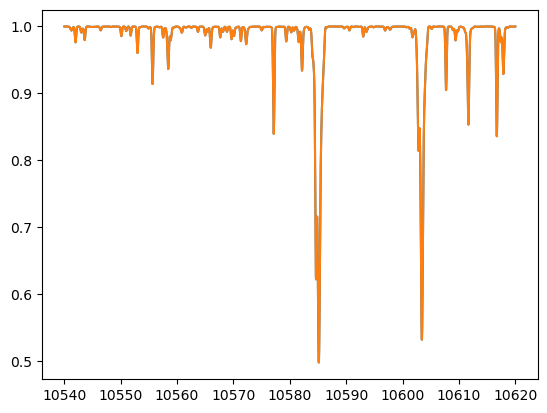

In [12]:
plt.plot(s.wav, s.flux)
s.read_spectra(remove=False)
plt.plot(s.wav, s.flux)



For other parameters which is not introduced here, please refer to the comment lines of each function.

After we understand how to use `synth`, the usage of other classese are similar.

## `abfind`

In [22]:
ges_linelist = pymoog.line_data.read_linelist('ges')
ges_linelist = ges_linelist[(ges_linelist['wavelength'] > 8000) & (ges_linelist['wavelength'] < 8100) & (ges_linelist['EW'] > 15)]
ges_linelist = ges_linelist[(ges_linelist['id'] == 26) | (ges_linelist['id'] == 14)]
ges_linelist

,wavelength,id,EP,loggf,C6,D0,EW
85992,8002.576,26.0,4.580,-1.618,-7.79,NaN,22.80
86381,8026.940,14.0,6.261,-1.004,-6.98,NaN,34.24
86400,8027.941,26.0,3.252,-2.785,-7.73,NaN,28.46
86401,8028.313,26.0,4.473,-0.686,-7.54,NaN,76.66
86520,8035.618,14.0,5.984,-1.372,-7.16,NaN,24.95
86696,8046.047,26.0,4.415,-0.100,-7.55,NaN,125.55
86735,8047.617,26.0,0.859,-4.742,-7.85,NaN,50.73
86750,8049.366,14.0,6.269,-1.287,-6.98,NaN,20.15
87069,8071.283,14.0,6.099,-1.192,-7.06,NaN,31.16
87075,8072.164,26.0,2.424,-3.519,-7.82,NaN,32.43


In [3]:
a = pymoog.abfind.abfind(5777, 4.0, 0, line_list=ges_linelist)
a.prepare_file()
a.run_moog()
a.read_output()

## `blends`

In [2]:
ges_linelist = pymoog.line_data.read_linelist('ges')
ges_linelist = ges_linelist[(ges_linelist['wavelength'] > 8000) & (ges_linelist['wavelength'] < 8010)]


In [3]:
w = pymoog.weedout.weedout(5060, 4.7, 0, 8002.576-0.5, 8002.576+0.5, line_list=ges_linelist)
w.prepare_file()
w.run_moog()
w.read_linelist(remove=False)
w.compare(50000)

In [4]:
w.keep_list

,wavelength,id,EP,loggf,C6,D0,EW
0,8002.576,26.0,4.58,-1.618,-7.79,NaN,NaN


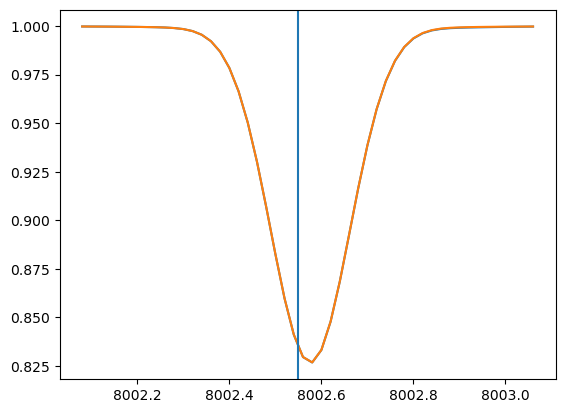

In [5]:
plt.plot(w.wav_all, w.flux_all)
plt.plot(w.wav_keep, w.flux_keep)

plt.axvline(8002.55)

In [7]:
np.sum(1-w.flux_all)*0.02*1000

37.74519999999999

In [7]:
b = pymoog.blends.blends(5777, 4.0, 0, 8002.576-0.5, 8002.576+0.5, 37.74, 26)
b.prepare_file()
b.run_moog(output=True)
b.read_output()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER blends 
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY ABUNDANCE OUTPUT; here is the filename: MOOG.out2                       
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [8]:
b.blends_s_df

,wavelength,ID,EP,logGF,EWin,logRWin,abund,delavg
0,8002.576,26.0,4.58,-1.618,37.74,-5.326,7.689,0.0


## `cog`

In [2]:
vald = pymoog.line_data.read_linelist('vald_winered')

In [3]:
t = vald.loc[1000:1000]
t.loc[1000, 'loggf'] = -3

/tmp/ipykernel_3917791/681715747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.loc[1000, 'loggf'] = -3


In [4]:
c = pymoog.cog.cog(5000, 4, 0, line_list=vald.loc[1000:1000])
c.prepare_file()
c.run_moog()
c.read_output()

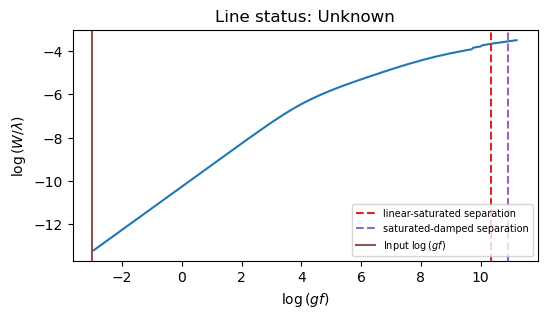

In [5]:
c.get_line_status(plot='cog')

In [7]:
with open('/home/mingjie/.pymoog/cog-05:37:44.366958/MOOG.out2', 'r') as file:
    cog_content = file.readlines()

cog_single_content = [ele.replace(' ', ',').split() for ele in cog_content[6:]]
# cog_single_content = [item for sublist in cog_single_content for item in sublist]
# cog_array = private.np.array(cog_single_content, dtype=float).reshape(-1,2)
# loggf = cog_array[:,0]
# logrw = cog_array[:,1]

In [8]:
cog_single_content

[[',-5.526,-15.795,-5.476,-15.745,-5.426,-15.695,-5.376,-15.645,-5.326,-15.595'],
 [',-5.276,-15.545,-5.226,-15.495,-5.176,-15.445,-5.126,-15.395,-5.076,-15.345'],
 [',-5.026,-15.295,-4.976,-15.245,-4.926,-15.195,-4.876,-15.145,-4.826,-15.095'],
 [',-4.776,-15.045,-4.726,-14.995,-4.676,-14.945,-4.626,-14.895,-4.576,-14.845'],
 [',-4.526,-14.795,-4.476,-14.745,-4.426,-14.695,-4.376,-14.645,-4.326,-14.595'],
 [',-4.276,-14.545,-4.226,-14.495,-4.176,-14.445,-4.126,-14.395,-4.076,-14.345'],
 [',-4.026,-14.295,-3.976,-14.245,-3.926,-14.195,-3.876,-14.145,-3.826,-14.095'],
 [',-3.776,-14.045,-3.726,-13.995,-3.676,-13.945,-3.626,-13.895,-3.576,-13.845'],
 [',-3.526,-13.795,-3.476,-13.745,-3.426,-13.695,-3.376,-13.645,-3.326,-13.595'],
 [',-3.276,-13.545,-3.226,-13.495,-3.176,-13.445,-3.126,-13.395,-3.076,-13.345'],
 [',-3.026,-13.295,-2.976,-13.245,-2.926,-13.195,-2.876,-13.145,-2.826,-13.095'],
 [',-2.776,-13.045,-2.726,-12.995,-2.676,-12.945,-2.626,-12.895,-2.576,-12.845'],
 [',-2.526,-12.7

## `weedout`: remove the weak lines

In [2]:
w = pymoog.weedout.weedout(5000, 2, 0, 10800, 10820)
w.prepare_file(model_type='kurucz')
w.run_moog()
w.read_linelist()
w.compare(50000)
# w.keeplines, w.tosslinesoss

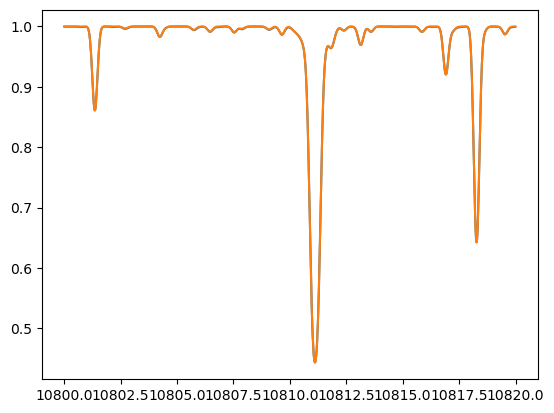

In [4]:
plt.plot(w.wav_all, w.flux_all)
plt.plot(w.wav_keep, w.flux_keep)

## synpop

In [10]:
# Prepare three models 
s = pymoog.synth.synth(5060, 4.7, 0, 10540, 10620, 50000, vmicro=2, mass=1, del_wav=0.02, 
                       line_list='vald_3000_24000', weedout=False, prefix='')
s.prepare_file(model_file=None, model_format='moog', loggf_cut=None, abun_change=None, molecules=None, 
               atmosphere=1, lines=1, smooth_para=None, model_type='marcs', model_chem='st', model_geo='auto')
s.run_moog(output=False)
# s.read_spectra()

In [13]:
path = s.rundir_path

In [16]:
pymoog.model.interpolate_model(7000, 3.8, -0.3, save_name=path+'MODEL3')

## Other functions

There are some funcitons in the package which is not in MOOG, but developed by Mingjie.
Here we will introduce them.